# Feature Importance Testing
1. Feature importance is first calculated using the Random Forest Classifier.  
    1.1. Radom Forest is trained on the training data (ib)   
    1.2. Feature importance is calculated using the trained model but with the test data (oob)  
    1.3.  Another Random Forest is trained on the permuted training data (ib), which constitutes the null hypothesis.  
    1.4. Feature importance is calculated using the trained model but with the test data (oob)  
2. p-values are calculated for each feature using the permutation method.   
    2.1. The p-value is calculated as the proportion of times the permuted feature importance is greater than the original feature importance.   


In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import os
import sktree
from collections import defaultdict
# copy the model
from copy import deepcopy

# supress the warning
import warnings
warnings.filterwarnings("ignore")

In [4]:
# load the Wise dataset
wise = pd.read_csv('./wise.matrix')
display(wise.head())
# print(wise.shape)
wise_y = wise['Cancer Status']
wise_X = wise.drop(columns = ['Cancer Status', 'Sample', 'Tumor type', 'Stage'])
# display(wise_X.head())
print(wise_X.shape)

,Sample,Cancer Status,Stage,Tumor type,1:1-10000000,1:10000001-20000000,1:20000001-30000000,1:30000001-40000000,1:40000001-50000000,1:50000001-60000000,...,21:10000001-20000000,21:20000001-30000000,21:30000001-40000000,21:40000001-50000000,22:1-10000000,22:10000001-20000000,22:20000001-30000000,22:30000001-40000000,22:40000001-50000000,22:50000001-60000000
0,S0035.INDI_998_PLS_1,1,IV,Ovary,0.107617,-0.089664,0.088308,0.161890,0.195141,0.059390,...,-1.072653,-0.931427,-0.835283,-0.817325,0.0,-1.819371,-1.749369,-1.684808,-1.647312,-1.532646
1,S0035.INDI_983_PLS_1,1,IV,Ovary,-0.772378,-1.087627,-0.949005,0.489450,-0.670958,-0.221170,...,-0.897900,-0.524623,-0.922448,-0.793396,0.0,-0.675361,-0.943580,-0.758821,-0.932769,-0.749762
2,S0035.INDI_510_PLS_1A,1,IV,Ovary,-1.519912,-1.795528,-1.847208,0.015104,0.541656,0.411293,...,-0.796892,0.147432,-0.221206,-0.270937,0.0,-3.158424,-1.795942,-1.927368,-1.657170,-1.819905
3,S0063.INDIA_3343_PLS_1,1,IIIA,Lung,3.058270,2.851708,2.665363,-0.828755,-0.752899,-0.695762,...,-1.603144,-1.409415,-0.781825,-0.207052,0.0,2.169607,1.920353,-0.745165,-0.920590,-0.716167
4,S0064.INDIA_3360_PLS_1,1,IIB,Lung,0.017034,0.189540,-0.901394,-0.537247,-0.986964,-0.564267,...,0.044192,0.188299,0.263522,1.150110,0.0,-0.045028,-0.220047,0.243085,1.025034,1.885327


(704, 300)


In [8]:
# Wise
wise_all = pd.read_csv('./wise_All.matrix')
display(wise_all.head())
print(wise_all.shape)
# drop nan rows
# wise_all = wise_all.dropna()
wise_all_y = wise_all['Cancer Status']
# map the cancer status to 0 and 1
wise_all_y = wise_all_y.map({'Healthy':0, 'Cancer':1})
wise_all_X = wise_all.drop(columns = ['Run','Library','Cancer Status', 'Sample', 'Tumor type', 'Stage'])
display(wise_all_X.head(10))
print(wise_all_X.shape)

,Run,Sample,Library,Cancer Status,Stage,Tumor type,1:1-10000000,1:10000001-20000000,1:20000001-30000000,1:30000001-40000000,...,21:10000001-20000000,21:20000001-30000000,21:30000001-40000000,21:40000001-50000000,22:1-10000000,22:10000001-20000000,22:20000001-30000000,22:30000001-40000000,22:40000001-50000000,22:50000001-60000000
0,S0028,INDI_918_PLS_1A,A387-12,Cancer,IV,Stomach,0.468038,-3.145530,-1.712623,-0.735046,...,-1.135428,0.910290,-0.814004,0.465840,NaN,-2.455095,0.242265,-0.999295,0.586578,4.020335
1,S0028,INDI_980_PLS_1,A387-13,Cancer,IV,Stomach,0.632628,-3.349720,-0.246645,-0.336667,...,-0.728640,0.982447,-1.233654,1.355670,NaN,2.373436,4.932168,-0.335874,0.462123,2.862172
2,S0034,INDI_580_PLS_1A,A396-13,Cancer,IV,Colorectal,-2.123124,-2.840198,-2.896575,-2.638872,...,0.540503,-0.127143,-0.174641,0.031823,NaN,0.298749,-0.050700,-0.240639,0.109563,0.532129
3,S0034,INDI_730_PLS_1A,A396-04,Cancer,IV,Pancreas,-1.318004,-1.953182,-1.099582,-0.309286,...,0.567452,-0.766169,-0.743883,1.192330,NaN,-2.766405,0.101859,-1.526696,0.981383,-1.887319
4,S0034,INDI_481_PLS_1A,A396-10,Cancer,IV,Liver,0.199915,-1.960120,-1.531292,-0.322800,...,-2.222321,0.856329,-0.179628,-0.078619,NaN,-7.305575,-3.274674,-1.136304,-0.444130,0.926091


(1991, 306)


,1:1-10000000,1:10000001-20000000,1:20000001-30000000,1:30000001-40000000,1:40000001-50000000,1:50000001-60000000,1:60000001-70000000,1:70000001-80000000,1:80000001-90000000,1:90000001-100000000,...,21:10000001-20000000,21:20000001-30000000,21:30000001-40000000,21:40000001-50000000,22:1-10000000,22:10000001-20000000,22:20000001-30000000,22:30000001-40000000,22:40000001-50000000,22:50000001-60000000
0,0.468038,-3.145530,-1.712623,-0.735046,-0.596196,-0.984366,-0.614533,1.040431,0.854524,-0.618427,...,-1.135428,0.910290,-0.814004,0.465840,NaN,-2.455095,0.242265,-0.999295,0.586578,4.020335
1,0.632628,-3.349720,-0.246645,-0.336667,-0.261915,-0.313818,-0.506784,0.677787,0.877207,0.171904,...,-0.728640,0.982447,-1.233654,1.355670,NaN,2.373436,4.932168,-0.335874,0.462123,2.862172
2,-2.123124,-2.840198,-2.896575,-2.638872,-2.749420,-2.938617,-3.073245,-2.771971,-2.790879,-3.014190,...,0.540503,-0.127143,-0.174641,0.031823,NaN,0.298749,-0.050700,-0.240639,0.109563,0.532129
3,-1.318004,-1.953182,-1.099582,-0.309286,0.307930,-0.018172,-1.846236,1.093738,0.154590,-0.731298,...,0.567452,-0.766169,-0.743883,1.192330,NaN,-2.766405,0.101859,-1.526696,0.981383,-1.887319
4,0.199915,-1.960120,-1.531292,-0.322800,-1.294747,-2.039103,-2.074370,0.719124,-0.084680,-1.684656,...,-2.222321,0.856329,-0.179628,-0.078619,NaN,-7.305575,-3.274674,-1.136304,-0.444130,0.926091
5,-0.422501,-1.176739,-0.697730,-1.186666,-0.993333,-1.164834,-1.859197,0.043965,0.035079,-1.413566,...,-0.001860,0.271307,-0.340216,0.267407,NaN,0.056550,-1.119487,-0.573910,-0.036823,2.541237
6,-1.540736,-0.744457,0.743682,-0.083271,0.556707,0.127913,0.442714,0.580879,0.292343,-1.039185,...,-2.651988,0.216153,0.355764,1.720476,NaN,-5.747655,-2.281148,0.995363,-1.024352,-1.618191
7,0.107617,-0.089664,0.088308,0.161890,0.195141,0.059390,-0.047255,0.280065,0.129975,0.490819,...,-1.072653,-0.931427,-0.835283,-0.817325,NaN,-1.819371,-1.749369,-1.684808,-1.647312,-1.532646
8,-0.772378,-1.087627,-0.949005,0.489450,-0.670958,-0.221170,-1.017481,-0.763074,-1.123401,-1.173831,...,-0.897900,-0.524623,-0.922448,-0.793396,NaN,-0.675361,-0.943580,-0.758821,-0.932769,-0.749762
9,-1.792493,-1.873985,-1.624426,-0.908653,-1.056033,-1.400742,-2.057480,-1.632745,-1.389339,-1.619607,...,-2.676097,-1.865423,-0.871783,-0.392756,NaN,0.162990,0.307872,-0.712815,-0.793441,-0.515901


(1991, 300)


In [9]:
# remove the columns with all nan values
nan_cols = wise_all_X.isnull().all(axis=0).to_numpy()
print("number of columns with all nan values: ", np.sum(nan_cols))
# get the index of the columns with all nan values
nan_cols_idx = np.where(nan_cols)[0]
print(nan_cols_idx)
wise_all_X = wise_all_X.loc[:, ~nan_cols]
print(wise_all_X.shape)
wise_all_X.isnull().any(axis=1).sum()

number of columns with all nan values:  16
[ 12  13  89 114 162 163 164 215 227 228 238 239 252 258 289 294]
(1991, 284)


1963

In [10]:
# Functions to calculate the feature importance p-values
from sklearn.ensemble import RandomForestClassifier
from joblib import Parallel, delayed
from scipy.stats import false_discovery_control
from statsmodels.stats.multitest import multipletests

def statistics(feature_importance, idx, n_estimators=1000):
    r"""
    Helper function that calulates the feature importance
    test statistic.
    """
    stat = np.zeros(len(feature_importance[0]))
    for ii in range(n_estimators):
        r = ss.rankdata(1-feature_importance[idx[ii]], method="max")
        r_0 = ss.rankdata(1-feature_importance[idx[n_estimators + ii]], method="max")
        stat += (r_0 > r) * 1
    stat /= n_estimators
    return stat


def perm_stat(feature_importance, n_estimators=1000):
    r"""
    Helper function that calulates the null distribution.
    """
    idx = list(range(2 * n_estimators))
    # print(idx)
    np.random.shuffle(idx)
    # print(idx)
    return statistics(feature_importance, idx)


def test(feature_importance, n_repeats=1000, n_jobs=-1, n_estimators=1000):
    r"""
    Calculates p values for fearture imprtance test.
    Parameters
    ----------
    X : ArrayLike of shape (n_samples, n_features)
        The data matrix.
    y : ArrayLike of shape (n_samples, n_outputs)
        The target matrix.
    n_repeats : int, optional
        Number of times to sample the null distribution, by default 1000.
    n_jobs : int, optional
        Number of workers to use, by default 1000.
    Returns
    -------
    stat : float
        The computed discriminability statistic.
    pvalue : float
        The computed one sample test p-value.
    """
    stat = statistics(feature_importance, list(range(2 * n_estimators)), n_estimators=n_estimators)
    # print(stat)
    null_stat = Parallel(n_jobs=n_jobs)(
        delayed(perm_stat)(feature_importance, n_estimators=n_estimators)
        for _ in range(n_repeats)
    )
    count = np.sum((null_stat >= stat) * 1, axis=0)
    p_val = (1 + count) / (1 + n_repeats)
    # adjust p-value for multiple testing using Bonferroni-Holm correction
    # rank the p-values
    ranks = ss.rankdata(p_val)
    p_val_adusted = p_val * (len(p_val) - ranks + 1)
    p_val_adusted = p_val_adusted #/ np.max(p_val_adusted) # normalize the p-values. This is arbitrary
    return stat, p_val, p_val_adusted

In [11]:
# set the parameters
dataset = 'wise'
n_estimators = 10000
split = (0.5, 0.5)
n_repeats = 10000
n_jobs = -5
max_features = 1/3
# =================================================================================================
if dataset == 'wise':
    X = wise_X
    y = wise_y
if dataset == 'wise_all':
    X = wise_all_X
    y = wise_all_y
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split[1], random_state=None)
# train using 
model = RandomForestClassifier(n_estimators=n_estimators, n_jobs=n_jobs)
model.fit(X_train,y_train)
# test the model on the test data
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

# feature_importance_origin = model.feature_importances_
# feature_importance per tree is a array of size n_features, so you get a list of n_estimators arrays
feature_importance_origin = [tree.feature_importances_ for tree in model.estimators_]
# print(len(feature_importance_origin[0]))
permuted_model = RandomForestClassifier(n_estimators=n_estimators, n_jobs=n_jobs)
y_cp = y_train.copy()
# shuffle the labels
y_cp = np.random.permutation(y_cp)
# np.random.shuffle(y_cp)
permuted_model.fit(X_train,y_cp)
permuted_feature_importance = [tree.feature_importances_ for tree in permuted_model.estimators_]
# del permuted_model
feature_importance = np.concatenate((feature_importance_origin, permuted_feature_importance))
# print(len(feature_importance))
stat, p_val_ib_, p_val_ib_adjusted = test(feature_importance,
            n_repeats = n_repeats,
            n_jobs = n_jobs,
            n_estimators = n_estimators)
# get the feature importance from the model
mean_feature_importance_ib = model.feature_importances_
# create a dataframe to store the p-values and the feature importance
p_val_ib = pd.DataFrame({'feature':X_train.columns, 'p_value_ib':p_val_ib_, 'p_value_ib_adjusted':p_val_ib_adjusted, 'feature_importance_ib':mean_feature_importance_ib})
display(p_val_ib)

0.9602272727272727


,feature,p_value_ib,p_value_ib_adjusted,feature_importance_ib
0,1:1-10000000,1.000000,99.500000,0.000466
1,1:10000001-20000000,1.000000,99.500000,0.001079
2,1:20000001-30000000,0.997000,233.298070,0.001937
3,1:30000001-40000000,0.999600,217.912809,0.001303
4,1:40000001-50000000,1.000000,99.500000,0.000968
...,...,...,...,...
295,22:10000001-20000000,1.000000,99.500000,0.000773
296,22:20000001-30000000,1.000000,99.500000,0.000852
297,22:30000001-40000000,0.872613,221.643636,0.003402
298,22:40000001-50000000,0.998500,227.658034,0.001952


In [13]:
p_val_ib.sort_values(by='feature_importance_ib', ascending=False)[:20]

,feature,p_value_ib,p_value_ib_adjusted,feature_importance_ib
156,8:130000001-140000000,0.000100,0.029497,0.065806
157,8:140000001-150000000,0.000100,0.029497,0.050823
154,8:110000001-120000000,0.000100,0.029497,0.038498
155,8:120000001-130000000,0.000100,0.029497,0.038385
152,8:90000001-100000000,0.000100,0.029497,0.038063
150,8:70000001-80000000,0.000100,0.029497,0.033905
153,8:100000001-110000000,0.001100,0.312369,0.027611
145,8:20000001-30000000,0.000100,0.029497,0.027549
21,1:210000001-220000000,0.000100,0.029497,0.025967
80,4:100000001-110000000,0.000100,0.029497,0.024960


In [12]:
p_val_ib.sort_values(by='p_value_ib_adjusted', ascending=True)[:20]

,feature,p_value_ib,p_value_ib_adjusted,feature_importance_ib
145,8:20000001-30000000,0.000100,0.029497,0.027549
150,8:70000001-80000000,0.000100,0.029497,0.033905
152,8:90000001-100000000,0.000100,0.029497,0.038063
82,4:120000001-130000000,0.000100,0.029497,0.022965
154,8:110000001-120000000,0.000100,0.029497,0.038498
155,8:120000001-130000000,0.000100,0.029497,0.038385
21,1:210000001-220000000,0.000100,0.029497,0.025967
80,4:100000001-110000000,0.000100,0.029497,0.024960
287,20:50000001-60000000,0.000100,0.029497,0.016138
156,8:130000001-140000000,0.000100,0.029497,0.065806


# Apply the held-out set and get the feature importance

# Feature Importance using oob samples

In [9]:
# # collect all the samples at each node
# from collections import defaultdict
# # import copy
# from copy import deepcopy

# # 1. train a random forest model using X_train, y_train
# model = RandomForestClassifier(n_estimators=1000, n_jobs=10)
# model.fit(X_train, y_train)
# # 2. copy the model
# model_cp = deepcopy(model)
# # 3. for each tree in the model do the following
# for i, tree in enumerate(model.estimators_):
#     # 3.1. copy the tree
#     tree_cp = deepcopy(tree)
#     # 3.2. collect all the samples at each node
#     tree_nodes = defaultdict(list)
#     node_indicator = tree.decision_path(X_test)
#     leave_id = tree.apply(X_test)
#     for sample_id in range(X_test.shape[0]):
#         node_index = node_indicator.indices[node_indicator.indptr[sample_id]: node_indicator.indptr[sample_id + 1]]
#         for node in node_index:
#             tree_nodes[node].append(sample_id)
#     # 3.3. calcurate the gini impurity for each split node
#     for node in range(tree.tree_.node_count):
#         node = int(node)
#         sample_ids = tree_nodes[node]
#         if len(sample_ids) == 0:
#             tree_cp.tree_.impurity[node] = 0
#         tree_cp.tree_.impurity[node] = 1 - np.sum(np.square(np.bincount(np.array(y_test)[sample_ids]) / len(sample_ids)))
#     # compute the feature importance
#     tree_cp.tree_.compute_feature_importances(normalize=False)
#     # 3.4. replace the tree in the copied model with the new tree
#     model_cp.estimators_[i] = tree_cp
# # 4. normalize the feature importance of the copied model
# # oob_sample_feature_importance = model_cp.feature_importances_ / model_cp.feature_importances_.sum()
# print(model_cp.feature_importances_.shape)

# # print(test_sample_feature_importance)

In [14]:
# define the function to calculate the feature importance using the oob samples
def get_oob_feature_importance(model, X_test, y_test, X_train=None, y_train=None, n_estimators=1000, n_jobs=10, return_model=False, max_features=None):
    r"""
    Calculate the feature importance using the oob samples. The feature importance is calculated by
    calcurating the gini impurity for each node in each tree in the random forest model. Here we use the oob samples
    to calculate the gini impurity instead of the training samples.

    Parameters
    ----------
    model : RandomForestClassifier
        The trained random forest model.
    X_test : ArrayLike of shape (n_samples, n_features)
        The test data matrix.
    y_test : ArrayLike of shape (n_samples, n_outputs)
        The test target matrix.
    X_train : ArrayLike of shape (n_samples, n_features), optional
        The training data matrix, by default None.
    y_train : ArrayLike of shape (n_samples, n_outputs), optional
        The training target matrix, by default None.
    Returns
    -------
    ArrayLike of shape (n_features,)
        The feature importance.
    """
    # 0. Check if the model is trained
    if not hasattr(model, 'estimators_'):
        if X_train is None or y_train is None:
            raise ValueError("The model is not trained. Please provide the training data.")
        else:
             # 1. train a random forest model using X_train, y_train (if X_train and y_train are provided)
            model = RandomForestClassifier(n_estimators=n_estimators, n_jobs=n_jobs, max_features=max_features)
            model.fit(X_train, y_train)
    # 2. copy the model
    model_cp = deepcopy(model)
    # 3. for each tree in the model do the following
    for i, tree in enumerate(model.estimators_):
        # 3.1. copy the tree
        tree_cp = deepcopy(tree)
        # 3.2. collect all the samples at each node
        tree_nodes = defaultdict(list)
        node_indicator = tree.decision_path(X_test)
        leave_id = tree.apply(X_test)
        for sample_id in range(X_test.shape[0]):
            node_index = node_indicator.indices[node_indicator.indptr[sample_id]: node_indicator.indptr[sample_id + 1]]
            # check if the nodes in the node_indicator are the same as the nodes in the tree
            assert np.array_equal(len(tree.tree_.impurity), tree.tree_.node_count)
            for node in node_index:
                tree_nodes[node].append(sample_id)
        # 3.3. calcurate the gini impurity for each node
        for node in range(tree.tree_.node_count):
            node = int(node)
            sample_ids = tree_nodes[node]
            if len(sample_ids) == 0:
                tree_cp.tree_.impurity[node] = 0
            tree_cp.tree_.impurity[node] = 1 - np.sum(np.square(np.bincount(np.array(y_test)[sample_ids]) / len(sample_ids)))
        # compute the feature importance
        tree_cp.tree_.compute_feature_importances(normalize=False)
        # 3.4. replace the tree in the copied model with the new tree
        model_cp.estimators_[i] = tree_cp
    # 4. normalize the feature importance of the copied model
    oob_sample_feature_importance = [tree.feature_importances_ for tree in model_cp.estimators_]
    if return_model:
        return oob_sample_feature_importance, model_cp
    else:
        return oob_sample_feature_importance

In [15]:
# define the function to calculate in-bag and out-of-bag feature importance
def get_feature_importances(model, X_train, y_train, X_test, y_test, n_estimators=1000, n_jobs=10, return_model=False, max_features=None):
    r"""
    Calculate the in-bag and out-of-bag feature importance of the random forest model.

    Parameters
    ----------
    model : RandomForestClassifier
        The trained random forest model.
    X_train : ArrayLike of shape (n_samples, n_features)
        The training data matrix.
    y_train : ArrayLike of shape (n_samples, n_outputs)
        The training target matrix.
    X_test : ArrayLike of shape (n_samples, n_features)
        The test data matrix.
    y_test : ArrayLike of shape (n_samples, n_outputs)
        The test target matrix.
    n_estimators : int, optional
        The number of trees in the random forest model, by default 1000.
    n_jobs : int, optional
        The number of workers to use, by default 10.
    Returns
    -------
    ArrayLike of shape (n_features,)
        The in-bag feature importance.
    ArrayLike of shape (n_features,)
        The out-of-bag feature importance.
    """
    # 1. train a random forest model using X_train, y_train
    model.fit(X_train, y_train)
    # 2. get the out-of-bag feature importance
    oob_sample_feature_importance = get_oob_feature_importance(model, X_test, y_test, X_train, y_train, n_estimators=n_estimators, n_jobs=n_jobs)
    # 3. get the in-bag feature importance
    in_bag_sample_feature_importance = [tree.feature_importances_ for tree in model.estimators_]
    return in_bag_sample_feature_importance, oob_sample_feature_importance

In [16]:
# get the in-bag and out-of-bag feature importance
model = RandomForestClassifier(n_estimators=n_estimators, n_jobs=n_jobs, max_features=max_features)
in_bag_sample_feature_importance, oob_sample_feature_importance = get_feature_importances(model, X_train, y_train, X_test, y_test, n_estimators=n_estimators, n_jobs=n_jobs, max_features=max_features)

In [17]:
# get the permuted feature importance
permuted_model = RandomForestClassifier(n_estimators=n_estimators, n_jobs=n_jobs, max_features=max_features)
y_train_permuted = y_train.copy()
# shuffle the labels
y_train_permuted = np.random.permutation(y_train_permuted)
# get the in-bag and out-of-bag feature importance
in_bag_sample_feature_importance_permuted, oob_sample_feature_importance_permuted = get_feature_importances(permuted_model, X_train, y_train_permuted, X_test, y_test, n_estimators=n_estimators, n_jobs=n_jobs, max_features=max_features)

In [18]:
# calcurate p-value for the feature importance with the oob samples
feature_importance_test = np.concatenate((oob_sample_feature_importance, oob_sample_feature_importance_permuted))
# print(len(feature_importance))
stat_oob, p_val_oob_, p_val_oob_adjusted = test(feature_importance_test,
            n_repeats = n_repeats,
            n_jobs = n_jobs,
            n_estimators = n_estimators)

In [19]:
# calcurate p-value for the feature importance with the in-bag samples
feature_importance_test = np.concatenate((in_bag_sample_feature_importance, in_bag_sample_feature_importance_permuted))
# print(len(feature_importance))
stat_ib, p_val_ib_, p_val_ib_adjusted = test(feature_importance_test,
            n_repeats = n_repeats,
            n_jobs = n_jobs,
            n_estimators = n_estimators)

In [20]:
p_val_ib['p_value_ib'] = p_val_ib_
p_val_ib['p_value_ib_adjusted'] = p_val_ib_adjusted
mean_feature_importance_ib = np.mean(in_bag_sample_feature_importance, axis=0)
mean_feature_importance_ib_permuted = np.mean(in_bag_sample_feature_importance_permuted, axis=0)
p_val_ib['feature_importance_ib'] = mean_feature_importance_ib
p_val_ib['feature_importance_ib_permuted'] = mean_feature_importance_ib_permuted
p_val_ib.sort_values(by='p_value_ib_adjusted', ascending=True).head(20)

,feature,p_value_ib,p_value_ib_adjusted,feature_importance_ib,feature_importance_ib_permuted
67,3:170000001-180000000,0.000100,0.029297,0.010059,0.002302
155,8:120000001-130000000,0.000100,0.029297,0.040515,0.004289
154,8:110000001-120000000,0.000100,0.029297,0.056360,0.001888
21,1:210000001-220000000,0.000100,0.029297,0.039777,0.001986
152,8:90000001-100000000,0.000100,0.029297,0.052082,0.003617
18,1:180000001-190000000,0.000100,0.029297,0.013612,0.001956
17,1:170000001-180000000,0.000100,0.029297,0.031932,0.001599
15,1:150000001-160000000,0.000100,0.029297,0.016853,0.001998
156,8:130000001-140000000,0.000100,0.029297,0.212732,0.003395
80,4:100000001-110000000,0.000100,0.029297,0.039613,0.001784


In [25]:
mean_feature_importance_oob = np.mean(oob_sample_feature_importance, axis=0)
mean_feature_importance_oob_permuted = np.mean(oob_sample_feature_importance_permuted, axis=0)
p_val_oob = pd.DataFrame({'feature':X_train.columns, 'p_value_oob':p_val_oob_, 'p_value_oob_adjusted':p_val_oob_adjusted, 'feature_importance_oob':mean_feature_importance_oob, 'feature_importance_oob_permuted':mean_feature_importance_oob_permuted})
# p_val_oob = p_val_oob.set_index('feature')
# display(p_val_oob.head(10))
p_val_oob.sort_values(by='p_value_oob_adjusted', ascending=True).head(20)
# set 

,feature,p_value_oob,p_value_oob_adjusted,feature_importance_oob,feature_importance_oob_permuted
156,8:130000001-140000000,0.0001,0.029997,0.312379,0.004730
0,1:1-10000000,1.0000,150.000000,0.000044,0.001387
203,12:20000001-30000000,1.0000,150.000000,0.000570,0.001272
202,12:10000001-20000000,1.0000,150.000000,-0.001148,0.002752
201,12:1-10000000,1.0000,150.000000,-0.000140,0.000025
200,11:130000001-140000000,1.0000,150.000000,0.001102,0.003628
199,11:120000001-130000000,1.0000,150.000000,0.000009,-0.000341
198,11:110000001-120000000,1.0000,150.000000,0.000004,0.001976
197,11:100000001-110000000,1.0000,150.000000,-0.000076,0.000384
196,11:90000001-100000000,1.0000,150.000000,0.000131,-0.000070


In [27]:
# Run this only once
# join the two dataframes
p_val_oob = p_val_oob.set_index('feature')
p_val_ib = p_val_ib.set_index('feature')
p_val_ib_oob = p_val_ib.join(p_val_oob, how = 'inner')
print(p_val_ib_oob.shape)
# make the index as a column
p_val_ib_oob.reset_index(inplace=True)
p_val_ib_oob

(300, 8)


,feature,p_value_ib,p_value_ib_adjusted,feature_importance_ib,feature_importance_ib_permuted,p_value_oob,p_value_oob_adjusted,feature_importance_oob,feature_importance_oob_permuted
0,1:1-10000000,1.000000,96.500000,0.000152,0.002775,1.0,150.0,0.000044,0.001387
1,1:10000001-20000000,1.000000,96.500000,0.000492,0.004107,1.0,150.0,0.000066,-0.018113
2,1:20000001-30000000,0.999900,195.980402,0.000489,0.001408,1.0,150.0,0.000134,0.001821
3,1:30000001-40000000,1.000000,96.500000,0.000730,0.003215,1.0,150.0,0.000110,0.001844
4,1:40000001-50000000,0.999700,206.937906,0.000379,0.001455,1.0,150.0,-0.000038,-0.002434
...,...,...,...,...,...,...,...,...,...
295,22:10000001-20000000,1.000000,96.500000,0.000444,0.001790,1.0,150.0,0.000163,0.000040
296,22:20000001-30000000,1.000000,96.500000,0.000941,0.003718,1.0,150.0,0.000344,-0.000603
297,22:30000001-40000000,0.829417,215.648435,0.001624,0.001231,1.0,150.0,0.000607,0.001742
298,22:40000001-50000000,1.000000,96.500000,0.000402,0.001913,1.0,150.0,0.000089,0.000424


In [28]:
p_val_ib_oob.sort_values(by='feature_importance_oob', ascending=False)[:10]

,feature,p_value_ib,p_value_ib_adjusted,feature_importance_ib,feature_importance_ib_permuted,p_value_oob,p_value_oob_adjusted,feature_importance_oob,feature_importance_oob_permuted
156,8:130000001-140000000,0.000100,0.029297,0.212732,0.003395,0.0001,0.029997,0.312379,0.004730
157,8:140000001-150000000,0.000100,0.029297,0.088278,0.001372,1.0000,150.000000,0.125362,0.003829
154,8:110000001-120000000,0.000100,0.029297,0.056360,0.001888,1.0000,150.000000,0.083756,0.001902
152,8:90000001-100000000,0.000100,0.029297,0.052082,0.003617,1.0000,150.000000,0.073112,0.003235
155,8:120000001-130000000,0.000100,0.029297,0.040515,0.004289,1.0000,150.000000,0.054084,-0.005250
150,8:70000001-80000000,0.020498,5.780422,0.035201,0.004908,1.0000,150.000000,0.053543,0.097404
21,1:210000001-220000000,0.000100,0.029297,0.039777,0.001986,1.0000,150.000000,0.031990,-0.000114
145,8:20000001-30000000,0.000100,0.029297,0.028084,0.006129,1.0000,150.000000,0.024963,0.015155
17,1:170000001-180000000,0.000100,0.029297,0.031932,0.001599,1.0000,150.000000,0.024320,0.000837
80,4:100000001-110000000,0.000100,0.029297,0.039613,0.001784,1.0000,150.000000,0.023044,0.002174


In [33]:
p_val_ib_oob.sort_values(by='p_value_oob_adjusted', ascending=True)[:20]

,feature,p_value_ib,p_value_ib_adjusted,feature_importance_ib,feature_importance_ib_permuted,p_value_oob,p_value_oob_adjusted,feature_importance_oob,feature_importance_oob_permuted
0,1:1-10000000,1.000000,101.000000,0.000625,0.003838,1.0,150.5,0.000179,0.000804
203,12:20000001-30000000,0.984302,246.075392,0.001877,0.002264,1.0,150.5,0.000672,0.015481
202,12:10000001-20000000,0.995900,239.016098,0.001521,0.002281,1.0,150.5,0.000496,0.007080
201,12:1-10000000,1.000000,101.000000,0.000954,0.002126,1.0,150.5,0.000567,0.004876
200,11:130000001-140000000,1.000000,101.000000,0.000622,0.002612,1.0,150.5,0.000212,-0.000766
199,11:120000001-130000000,1.000000,101.000000,0.000761,0.005610,1.0,150.5,0.000073,0.002298
198,11:110000001-120000000,1.000000,101.000000,0.000560,0.002874,1.0,150.5,0.000053,-0.000569
204,12:30000001-40000000,1.000000,101.000000,0.001888,0.003229,1.0,150.5,0.001172,0.002993
197,11:100000001-110000000,1.000000,101.000000,0.000778,0.004996,1.0,150.5,0.000186,0.015325
195,11:80000001-90000000,1.000000,101.000000,0.000528,0.004048,1.0,150.5,0.000186,0.010094


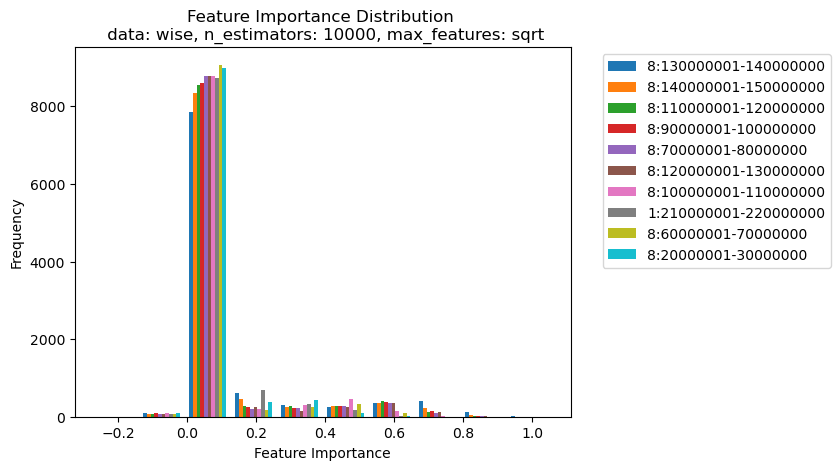

In [71]:
idx = p_val_ib_oob.sort_values(by='feature_importance_oob', ascending=False)[:10].index
plt.hist(np.array(oob_sample_feature_importance)[:, idx])
# # plt.hist(np.array(in_bag_sample_feature_importance)[:, 156])
# # plt.hist(np.array(in_bag_sample_feature_importance)[:, 154])
# # plt.hist(np.array(in_bag_sample_feature_importance)[:, 152])
plt.xlabel('Feature Importance')
plt.ylabel('Frequency')
plt.title(f'Feature Importance Distribution \n data: {dataset}, n_estimators: {n_estimators}, max_features: {max_features}')
# move the legend outside the plot
plt.legend(X_train.columns[idx], bbox_to_anchor=(1.05, 1), loc='upper left')


,feature,p_value_ib,p_value_ib_adjusted,feature_importance_ib,feature_importance_ib_permuted,p_value_oob,p_value_oob_adjusted,feature_importance_oob,feature_importance_oob_permuted
0,1:1-10000000,1.000000,99.500000,0.000668,0.002410,1.0,150.5,0.000122,0.000144
203,12:20000001-30000000,0.993501,239.433657,0.001732,0.002368,1.0,150.5,0.000432,0.001702
202,12:10000001-20000000,0.992001,240.064194,0.001595,0.002139,1.0,150.5,0.000010,0.003077
201,12:1-10000000,0.997200,233.344866,0.001570,0.002574,1.0,150.5,0.000391,-0.001167
200,11:130000001-140000000,1.000000,99.500000,0.000927,0.002212,1.0,150.5,0.000143,-0.000900
199,11:120000001-130000000,1.000000,99.500000,0.001094,0.003419,1.0,150.5,0.000072,0.000398
198,11:110000001-120000000,1.000000,99.500000,0.000566,0.003071,1.0,150.5,0.000036,0.002376
204,12:30000001-40000000,1.000000,99.500000,0.001076,0.004435,1.0,150.5,0.000715,0.005680
197,11:100000001-110000000,0.996800,235.244876,0.001037,0.001973,1.0,150.5,0.000144,0.001402
195,11:80000001-90000000,1.000000,99.500000,0.001155,0.004278,1.0,150.5,0.000085,0.002896


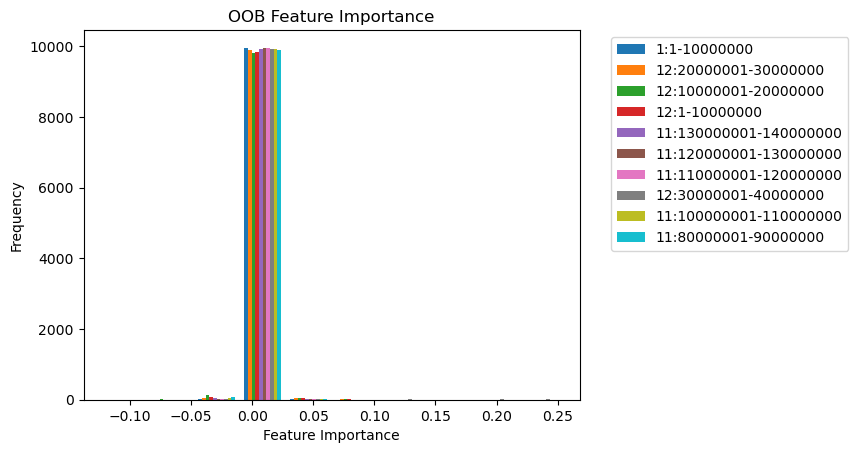

In [72]:
display(p_val_ib_oob.sort_values(by='p_value_oob_adjusted', ascending=True)[:10])
idx = p_val_ib_oob.sort_values(by='p_value_oob_adjusted', ascending=True)[:10].index
plt.hist(np.array(oob_sample_feature_importance)[:, idx])
# # plt.hist(np.array(in_bag_sample_feature_imptance)[:, 156])
# # plt.hist(np.array(in_bag_sample_feature_importance)[:, 154])
# # plt.hist(np.array(in_bag_sample_feature_importance)[:, 152])
plt.xlabel('Feature Importance')
plt.ylabel('Frequency')
plt.title('OOB Feature Importance')
# move the legend outside the plot
plt.legend(X_train.columns[idx], bbox_to_anchor=(1.05, 1), loc='upper left')

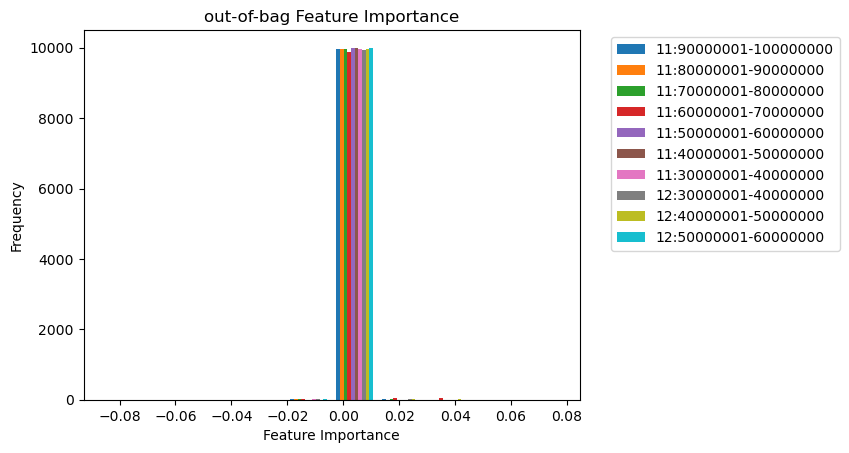

In [ ]:
idx = p_val_ib_oob.sort_values(by='p_value_oob', ascending=True)[10:20].index
plt.hist(np.array(oob_sample_feature_importance)[:, idx])
# # plt.hist(np.array(in_bag_sample_feature_importance)[:, 156])
# # plt.hist(np.array(in_bag_sample_feature_importance)[:, 154])
# # plt.hist(np.array(in_bag_sample_feature_importance)[:, 152])
plt.xlabel('Feature Importance')
plt.ylabel('Frequency')
plt.title('out-of-bag Feature Importance')
# move the legend outside the plot
plt.legend(X_train.columns[idx], bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
# X = wise_all_X
# y = wise_all_y
# X_0 = X.iloc[:, 152:158].to_numpy()
# # print(X_0.shape)
# y_0 = y
# X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_0, y_0, test_size=split[1], random_state=None)
# # print(X_train_0.shape)
# n_rep = 10
# res = []
# for i in range(n_rep):
#     model_0 = RandomForestClassifier(n_estimators=1000, n_jobs=10, max_features=None)
#     model_0.fit(X_train_0,y_train_0)
#     y_pred = model_0.predict(X_test_0)
#     from sklearn.metrics import accuracy_score
#     res.append(accuracy_score(y_test_0, y_pred))
# print(np.mean(res))

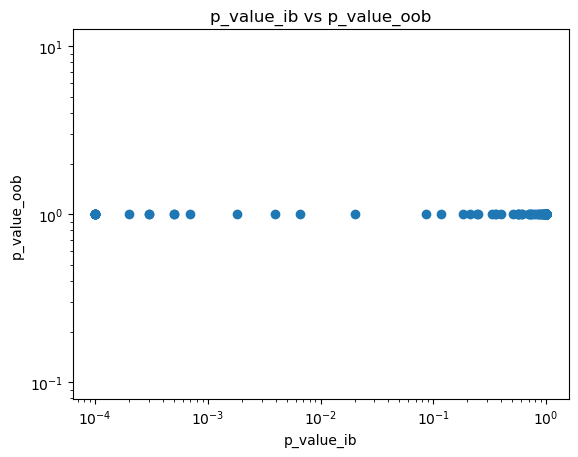

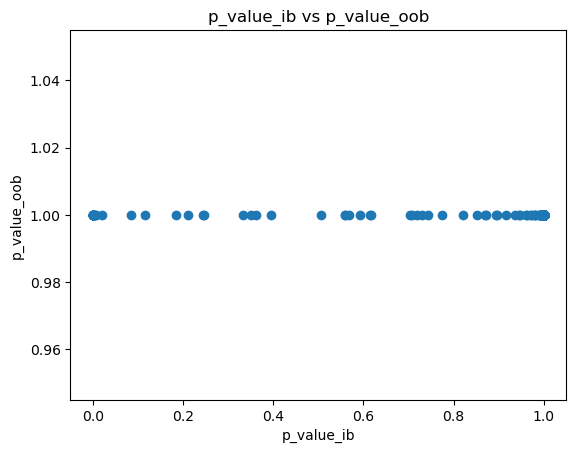

In [ ]:
# plot the 'p_value_ib' vs 'p_value_oob'
plt.scatter(p_val_ib_oob['p_value_ib'], p_val_ib_oob['p_value_oob'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('p_value_ib')
plt.ylabel('p_value_oob')
plt.title('p_value_ib vs p_value_oob')
plt.show()
plt.scatter(p_val_ib_oob['p_value_ib'], p_val_ib_oob['p_value_oob'])
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('p_value_ib')
plt.ylabel('p_value_oob')
plt.title('p_value_ib vs p_value_oob')
plt.show()

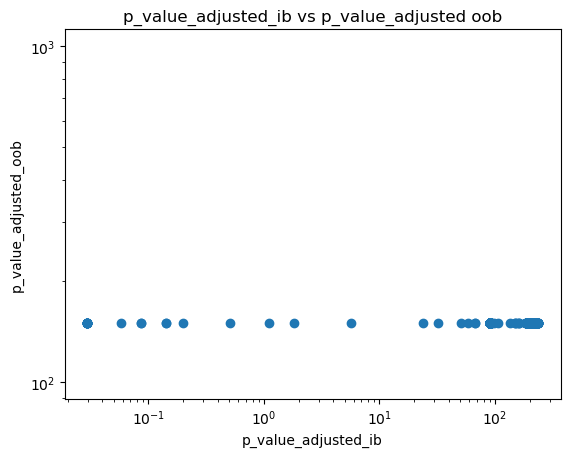

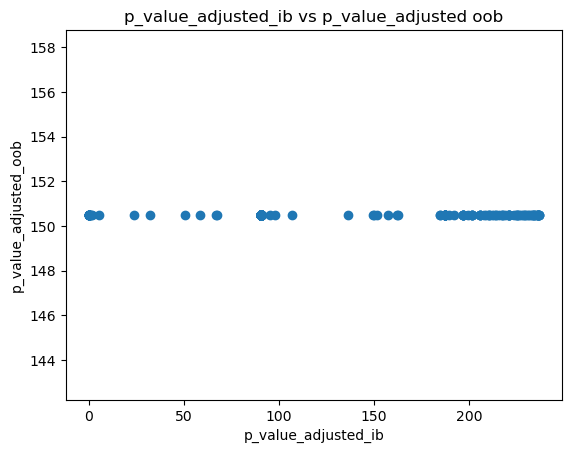

In [ ]:
# plot the 'p_value_adjusted_ib' vs 'p_value_adjusted_oob'
plt.scatter(p_val_ib_oob['p_value_ib_adjusted'], p_val_ib_oob['p_value_oob_adjusted'])
# plt.xlim(0, 1)
# plt.ylim(0, 1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('p_value_adjusted_ib')
plt.ylabel('p_value_adjusted_oob')
plt.title('p_value_adjusted_ib vs p_value_adjusted oob')
plt.show()

plt.scatter(p_val_ib_oob['p_value_ib_adjusted'], p_val_ib_oob['p_value_oob_adjusted'])
plt.xlabel('p_value_adjusted_ib')
plt.ylabel('p_value_adjusted_oob')
plt.title('p_value_adjusted_ib vs p_value_adjusted oob')
plt.show()

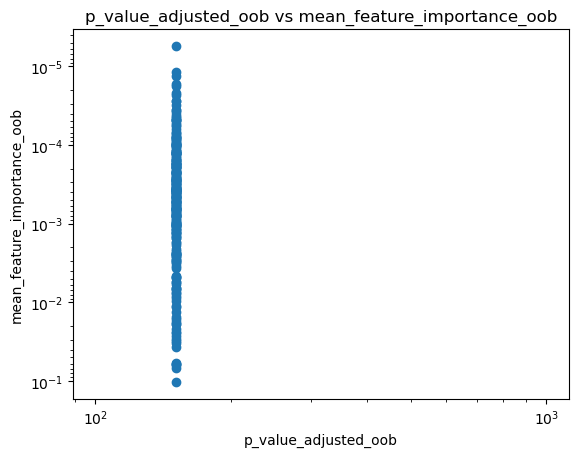

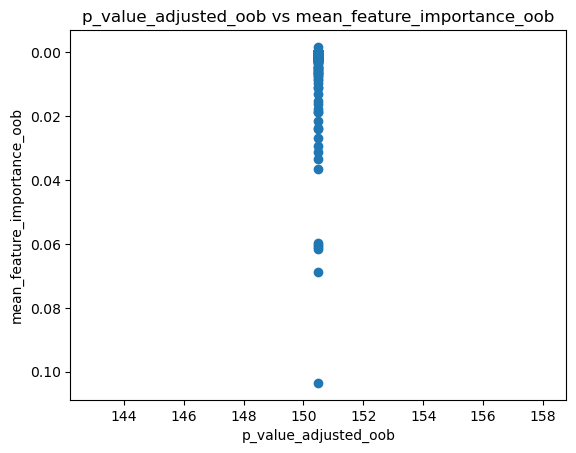

In [ ]:
# plot the 'p_value_adjusted_oob' vs 'mean_feature_importance_oob'
plt.scatter(p_val_ib_oob['p_value_oob_adjusted'], p_val_ib_oob['feature_importance_oob'])
# reverse the y-axis
plt.gca().invert_yaxis()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('p_value_adjusted_oob')
plt.ylabel('mean_feature_importance_oob')
plt.title('p_value_adjusted_oob vs mean_feature_importance_oob')
plt.show()

plt.scatter(p_val_ib_oob['p_value_oob_adjusted'], p_val_ib_oob['feature_importance_oob'])
plt.gca().invert_yaxis()
plt.xlabel('p_value_adjusted_oob')
plt.ylabel('mean_feature_importance_oob')
plt.title('p_value_adjusted_oob vs mean_feature_importance_oob')
plt.show()

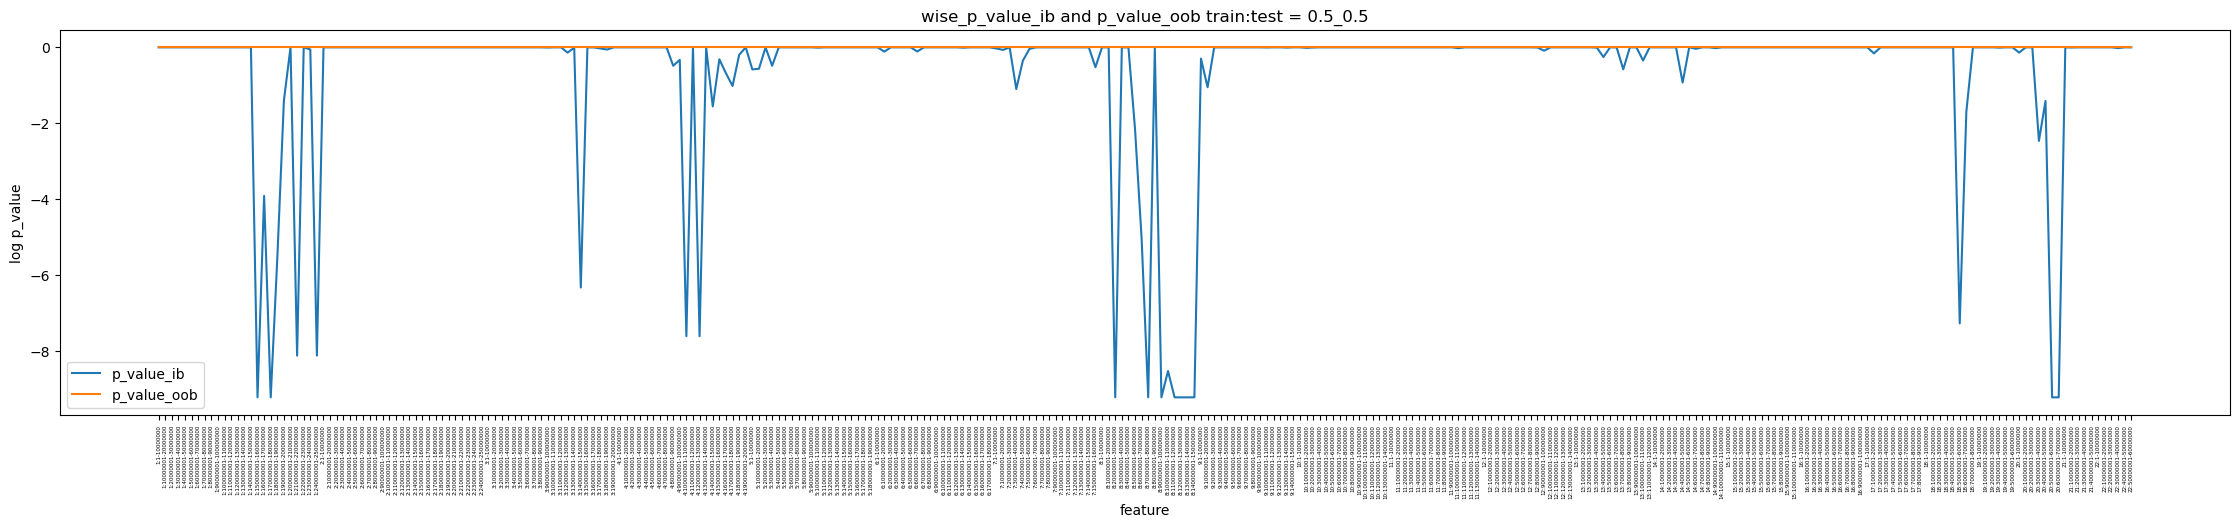

In [ ]:
# plot p_val_ib and p_val_oob of each feature
plt.figure(figsize=(28,5))
plt.plot(p_val_ib_oob['feature'], np.log(p_val_ib_oob['p_value_ib']), label = 'p_value_ib')
plt.plot(p_val_ib_oob['feature'], np.log(p_val_ib_oob['p_value_oob']), label = 'p_value_oob')
plt.xlabel('feature')
# make the xlabel smaller
plt.xticks(fontsize = 4)
plt.ylabel('log p_value')
plt.title(f'{dataset}_p_value_ib and p_value_oob train:test = {split[0]}_{split[1]}')
# rotate the x-axis labels by 90 degrees
plt.xticks(rotation=90)
plt.legend()
# save the plot
plt.savefig(f'{dataset}_p_value_ib_oob_{split[0]}_{split[1]}_{max_features}.png')
plt.show()

In [ ]:
# # sort the df by the p_value_ib
# p_val_ib_oob_sorted = p_val_ib_oob.sort_values(by = 'p_value_ib')
# plt.figure(figsize=(28,5))
# plt.plot(p_val_ib_oob_sorted['feature'], np.log(p_val_ib_oob_sorted['p_value_ib']), label = 'p_value_ib')
# plt.plot(p_val_ib_oob_sorted['feature'], np.log(p_val_ib_oob_sorted['p_value_oob']), label = 'p_value_oob')
# plt.xlabel('feature')
# # make the xlabel smaller
# plt.xticks(fontsize = 4)
# plt.ylabel('log p_value')
# plt.title(f'p_value_ib and p_value_oob train:test = {split[0]}:{split[1]}')
# # rotate the x-axis labels by 90 degrees
# plt.xticks(rotation=90)
# plt.legend()
# # save the plot
# # plt.savefig(f'p_value_ib_oob_{split[0]*10}_{split[1]*10}.png')
# plt.show()

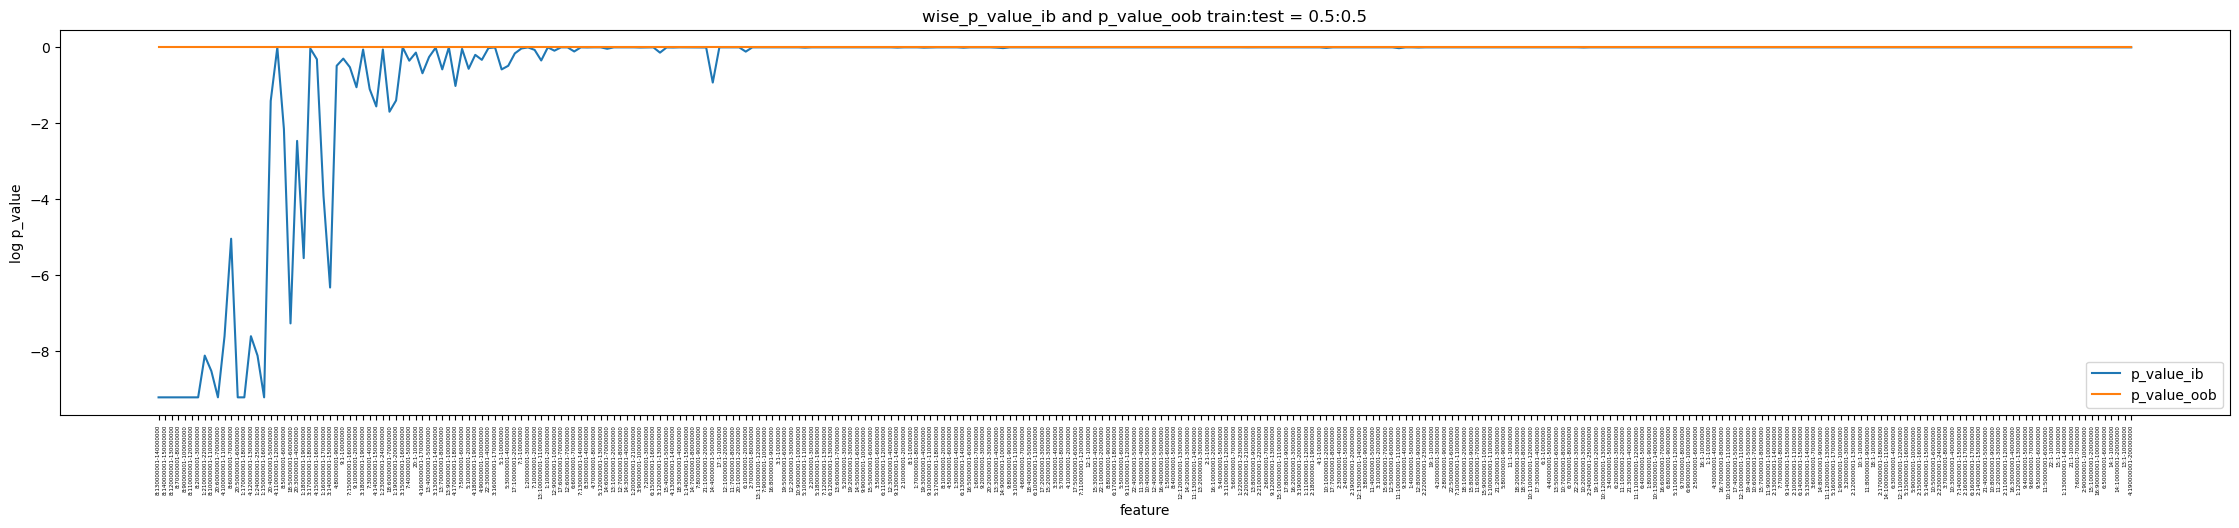

In [ ]:
p_val_ib_oob_sorted = p_val_ib_oob.sort_values(by = 'feature_importance_ib', ascending = False)
plt.figure(figsize=(28,5))
plt.plot(p_val_ib_oob_sorted['feature'], np.log(p_val_ib_oob_sorted['p_value_ib']), label = 'p_value_ib')
plt.plot(p_val_ib_oob_sorted['feature'], np.log(p_val_ib_oob_sorted['p_value_oob']), label = 'p_value_oob')
plt.xlabel('feature')
# make the xlabel smaller
plt.xticks(fontsize = 4)
plt.ylabel('log p_value')
plt.title(f'{dataset}_p_value_ib and p_value_oob train:test = {split[0]}:{split[1]}')
# rotate the x-axis labels by 90 degrees
plt.xticks(rotation=90)
plt.legend()
# save the plot
plt.savefig(f'{dataset}_p_value_ib_oob_{split[0]}_{split[1]}_{max_features}_sorted.png')
plt.show()

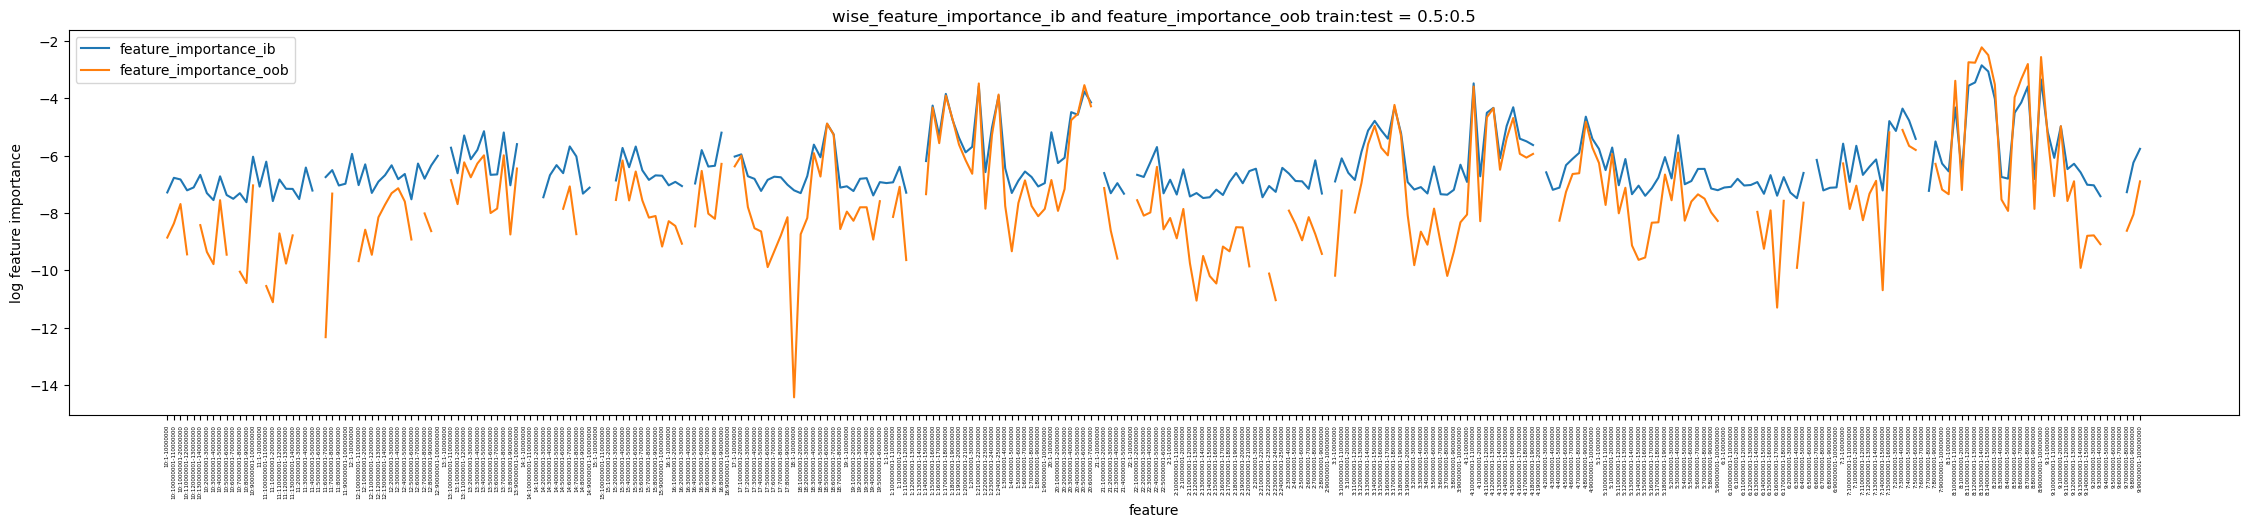

In [ ]:
p_val_ib_oob_sorted = p_val_ib_oob.sort_values(by='feature', ascending = True)
plt.figure(figsize=(28,5))
plt.plot(p_val_ib_oob_sorted['feature'], np.log(p_val_ib_oob_sorted['feature_importance_ib']), label = 'feature_importance_ib')
plt.plot(p_val_ib_oob_sorted['feature'], np.log(p_val_ib_oob_sorted['feature_importance_oob']), label = 'feature_importance_oob')
plt.xlabel('feature')
# make the xlabel smaller
plt.xticks(fontsize = 4)
plt.ylabel('log feature importance')
plt.title(f'{dataset}_feature_importance_ib and feature_importance_oob train:test = {split[0]}:{split[1]}')
# rotate the x-axis labels by 90 degrees
plt.xticks(rotation=90)
plt.legend()
# save the plot
plt.savefig(f'{dataset}_feature_importance_ib_oob_{split[0]}_{split[1]}_{max_features}.png')
plt.show()

In [ ]:
# from sklearn.inspection import permutation_importance
# result = permutation_importance(model, X_test, y_test, n_repeats=10, n_jobs=-5)
# sorted_importances_idx = result.importances_mean.argsort()
# # sort the columns by sorted_idx
# importances = pd.DataFrame(
#     result.importances[sorted_importances_idx].T,
#     columns=X_train.columns[sorted_importances_idx]
# )
# pd.DataFrame(importances.T.mean(axis=1), columns=['importance']).sort_values(by='importance', ascending=False)[:20]

In [ ]:
# get the mean feature importance from the random forest model
feature_importance_origin = [tree.feature_importances_ for tree in model.estimators_]
feature_importance = np.mean(feature_importance_origin, axis=0)

print(feature_importance.shape)
# get the column names
columns = wise_X.columns
print(columns.shape)
# create a dataframe
df = pd.DataFrame({'feature': columns, 'importance': feature_importance})
# sort the dataframe
df.sort_values('importance', ascending = False).to_csv("mean_feature_importance.csv",index=False)
df.sort_values('importance', ascending = False)[:20]


(300,)
(300,)


,feature,importance
156,8:130000001-140000000,0.066737
157,8:140000001-150000000,0.042778
155,8:120000001-130000000,0.040882
150,8:70000001-80000000,0.040192
152,8:90000001-100000000,0.036997
154,8:110000001-120000000,0.034724
145,8:20000001-30000000,0.027701
21,1:210000001-220000000,0.025969
153,8:100000001-110000000,0.023567
288,20:60000001-70000000,0.021655


In [ ]:
# pd.DataFrame(wise_X.columns[np.argsort(ss.rankdata(ps_adusted, method='min'))[:]]).to_csv('wise_rank.csv', index=False)
# pd.DataFrame(wise_X.columns[np.argsort(ss.rankdata(p_val, method='min'))[:]]).to_csv('wise_rank_pval.csv', index=False)

In [ ]:

X = wise_all_X
y = wise_all_y
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# train using 
model = RandomForestClassifier(n_estimators=1000, n_jobs=10)
permuted_model = RandomForestClassifier(n_estimators=1000, n_jobs=10)
model.fit(X_train,y_train)
# test the model on the test data
y_pred = model.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

# feature_importance_origin = model.feature_importances_
# del model
feature_importance_origin = [tree.feature_importances_ for tree in model.estimators_]
# print(len(feature_importance_origin[0]))
y_cp = y_train.copy()
# shuffle the labels
y_cp = np.random.permutation(y_cp)
# np.random.shuffle(y_cp)
permuted_model.fit(X_train,y_cp)
permuted_feature_importance = [tree.feature_importances_ for tree in permuted_model.estimators_]
# del permuted_model
feature_importance = np.concatenate((feature_importance_origin,permuted_feature_importance))
# print(len(feature_importance))
stat, p_val, ps_adusted = test(feature_importance,
            n_repeats = 1000,
            n_jobs = 10,
            n_estimators = 1000)

0.7694235588972431
